# Region Search as Vector Operations

In this notebook we look at how the question of finding images that could contain objects in terms of just 3-dimensional vector operations. Specifically we define image regions in terms of 3-dimensional cones in space. Each cone is defined by three parameters:
* `X`: A length 3 vector giving the coordinates of the cone's origin in heliocentric coordinates.
* `V`: A length 3 unit vector giving the directionality of the cone in heliocentric coordinates.
* `theta`: The half angle of the cone (the viewing radius).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Before we jump directly into operations on cones, let's look at how the central rays behave in 3-dimensional space. This is equivalent to a cone with `theta=0.0`.

In [2]:
# Two vectors starting from the earth's location and intersecting at point (0.5, 4.0, 1.0)
x1 = np.array([-1, 0, 0])
v1 = np.array([0.375, 1.0, 0.25])

x2 = np.array([1, 0, 0])
v2 = np.array([-0.125, 1.0, 0.25])

We can visualize each of the vectors in 3-d space using matplotlib.

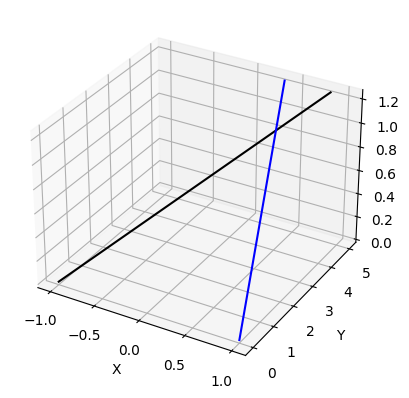

In [3]:
ax = plt.figure().add_subplot(projection='3d')

dists = np.linspace(0, 5, 100)

ax.plot(
    x1[0] + v1[0] * dists,
    x1[1] + v1[1] * dists,
    x1[2] + v1[2] * dists,
    color='black'
)
ax.plot(
    x2[0] + v2[0] * dists,
    x2[1] + v2[1] * dists,
    x2[2] + v2[2] * dists,
    color='blue'
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In addition we can use basic calculus to find the point of closest approach of the two rays. We start by noting that we want to minimize `|| P1 - P2 ||` where `P1 = X1 + t * V1` and `P2 = X2 + s * V2` for unknown distances along the rays `t` and `s`.

We use the approach described here: https://math.stackexchange.com/questions/1036959/midpoint-of-the-shortest-distance-between-2-rays-in-3d

In [4]:
def closest_point_rays(x1, v1, x2, v2) -> float:
    """Compute the closest distance two rays.
        
    Arguments
    ---------
    x1 : numpy.array
        A length 3 array with the origin of ray 1
    v1 : numpy.array
        A length 3 array with the directionality of ray 1
    x2 : numpy.array
        A length 3 array with the origin of ray 2
    v2 : numpy.array
        A length 3 array with the directionality of ray 2
    """
    v_dot = np.dot(v1, v2)
    v1_dot = np.dot(v1, v1)
    v2_dot = np.dot(v2, v2)
    
    # Find the "distance" along both rays
    scale = ((v1_dot * v2_dot) - v_dot*v_dot)
    t = (np.dot((x2 - x1), v1) * v2_dot + np.dot((x1 - x2), v2) * v_dot) / scale
    s = (np.dot((x1 - x2), v2) * v1_dot + np.dot((x2 - x1), v1) * v_dot) / scale

    # Compute the closest points.
    p1 = x1 + t * v1
    p2 = x2 + s * v2
    
    return np.sqrt(np.sum(np.square(p2-p1)))

In [5]:
# The closest point of two intersecting rays is 0.0.
closest_point_rays(x1, v1, x2, v2)

0.0

## Pointings

We define a `Pointing` class provides basic information for both our images and cone search. We use basic vector properties for the various checks. Right now just consider the `__init__` function which loads the data for the `Pointing`.

You can skip the other functions until they are referred to in the notebook.

In [6]:
class Pointing:
    def __init__(self, x0: list, v: list, theta: float):
        """
        Arguments
        ---------
        x0 : numpy.array
            A length 3 vector representing the 3-dimensional heliocentric coordinates of
            of the origin of the ray. In the case of images this is the coordinates of
            the observatory. For cone search this is [0, 0, 0].
        v : numpy.array
            A length 3 unit vector representing the direction of the pointing in the
            heliocentric coordinate system.
        theta : float
            The half-angle of the cone or image (in degrees).    
        """
        if len(x0) != 3:
            raise ValueError(f"Wrong length for Pointing's x0 ({len(x0)})")
        if len(v) != 3:
            raise ValueError(f"Wrong length for Pointing's v ({len(v)})")
        if abs(np.dot(v, v) - 1.0) > 1e-10:
            raise ValueError(f"Pointing's v must be a unit vector ({v})")
        if theta < 0 or theta >= 90.0:
            raise ValueError(f"Invalid theta for Pointing {theta}. Must be [0.0, 90.0)")
            
        self.x = np.array(x0)
        self.v = np.array(v)
        self.theta = theta
        self.cos_theta = np.cos((np.pi / 180.0) * theta)
        
    def point_in_cone(self, pt) -> bool:
        """Determine if a point in 3-d space falls within the cone.
        
        Arguments
        ---------
        pt : numpy.array
            A length 3 vector representing the 3-dimensional heliocentric coordinates
            of the point in question.
        """
        x_diff = pt - self.x
        return np.dot(x_diff, self.v) >= np.linalg.norm(x_diff) * self.cos_theta

We can use `Pointing` to create an observation out from a hypothetical telescope. We use geocentric coordinates with a perfectly circular orbit to compute the telescope’s position. We use a 10.0 degree field of view.

In [7]:
earth_angle = np.pi / 8.0
earth_pos = np.array([np.cos(earth_angle), np.sin(earth_angle), 0.0])
print(earth_pos)

pointing_angle = 3 * np.pi / 4.0
pointing_v = np.array([np.cos(pointing_angle), np.sin(pointing_angle), 0.0])
print(pointing_v)

view = Pointing(earth_pos, pointing_v, 5.0)

[0.92387953 0.38268343 0.        ]
[-0.70710678  0.70710678  0.        ]


## Testing Hypothetical Points

For KBMOD we need to determine whether the telescope image could contain pixels at a given heliocentric viewing vector `V` (unit numpy vector) and scalar distance `d`. Given these two pieces of information (in heliocentric coordinates), we can define the hypothetical object as a numpy array `obj = d * V`.

We define the `point_in_cone` function to perform a basic cone search check using for a given 3-dimensional numpy array `obj` and the `Pointing` called `view`. This search just uses the definition of the dot product:

`A . B = |A||B| cos(theta)`

In this case we want to compute the angle between the center of the cone (`view.v`) and the vector from the cone's origin to the object (`obj - view.x`). This gives us the equation:

`(obj - view.x) . (view.v) >= |(obj - view.x)||view.v| cos(view.theta)`

and since `view.v` is a unit vector:

`(obj - view.x) . (view.v) >= |(obj - view.x)| cos(view.theta)`

This total computation requires one vector subtraction, one dot product, one magnitude computation, and one multiplication. We can precompute the cosine for each view as we did in `__init__`.

We can create objects inside and outside the telescope's field of view and test that we get the right answers.

In [8]:
# Object 1 is directly in the line of sight.
obj1 = earth_pos + 5.0 * pointing_v
print(f"Object 1's {obj1} visibility is {view.point_in_cone(obj1)}")

# Object 2 is outside the line of sight.
obj2 = earth_pos + 5.0 * np.array([np.cos(np.pi/4.0), np.sin(np.pi/4.0), 0.0])
print(f"Object 2's {obj2} visibility is {view.point_in_cone(obj2)}")

Object 1's [-2.61165437  3.91821734  0.        ] visibility is True
Object 2's [4.45941344 3.91821734 0.        ] visibility is False


We can create a grid of points to visualize the this test.

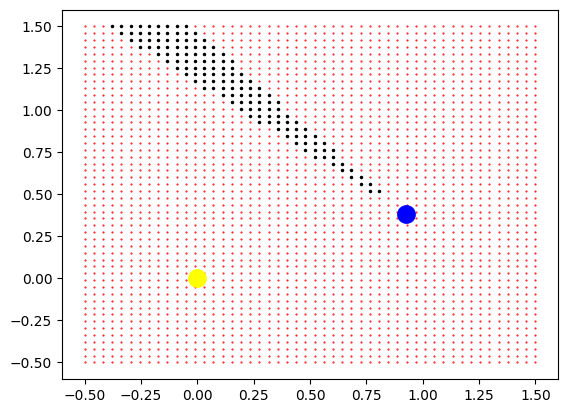

In [9]:
ax2 = plt.figure().add_subplot()

# Try a bunch of points around the Sun and Earth.
for x in np.linspace(-0.5, 1.5, 50):
    for y in np.linspace(-0.5, 1.5, 50):
        if view.point_in_cone(np.array([x, y, 0])):
            ax2.plot(x, y, color='black', marker='.', markersize=3)
        else:
            ax2.plot(x, y, color='red', marker='.', markersize=1)

# Plot the Sun and Earth for reference.
ax2.plot(0, 0, color='yellow', marker='.', markersize=25)
ax2.plot(earth_pos[0], earth_pos[1], color='blue', marker='.', markersize=25)

Using this approach we could store all 600m images as pointings (requiring < 100 bytes each) in 60GB and search through them for every proposed pointing and distance.

## Moving Beyond a Single Point

TODO...

In [10]:
# Fun function to plot the vectors in 3d in the context of the Sun and Earth's orbit.

# Note used in this notebook yet.
def plot_everything(pointings: list):
    ax = plt.figure().add_subplot(projection='3d')

    # Plot the sun and earth's (circular) orbit.
    ax.plot([0], [0], [0], color='yellow', marker='.')

    theta = np.linspace(0, 2 * np.pi, 100)
    earth_x = np.sin(theta)
    earth_y = np.cos(theta)
    earth_z = np.array([0] * len(theta))
    ax.plot(earth_x, earth_y, earth_z, color='blue')

    dists = np.linspace(0, 5, 100)
    for p in pointings:
        # Plot the end of the ray.
        ax.plot([p.x[0]], [p.x[1]], [p.x[1]], color='black', marker='.')
        
        x = p.x[0] + dists * p.v[0]
        y = p.x[1] + dists * p.v[1]
        z = p.x[2] + dists * p.v[2]
        ax.plot(x, y, z, color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

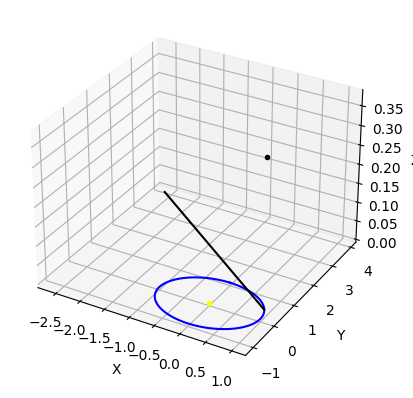

In [11]:
plot_everything([view])